<a href="https://colab.research.google.com/github/feather07170132/111-/blob/main/2023_01_01_cnn%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

**匯入資料集(搖滾樂)**

In [2]:
import gdown
import pandas as pd
url = 'https://raw.githubusercontent.com/feather07170132/111-/main/Data/1.%20%E6%90%96%E6%BB%BE%E8%81%AF%E5%90%88%E5%85%AC%E5%9C%92numb.csv'
gdown.download(url)
df = pd.read_csv(url, encoding='utf-8') # numb

Downloading...
From: https://raw.githubusercontent.com/feather07170132/111-/main/Data/1.%20%E6%90%96%E6%BB%BE%E8%81%AF%E5%90%88%E5%85%AC%E5%9C%92numb.csv
To: /content/1.%20%E6%90%96%E6%BB%BE%E8%81%AF%E5%90%88%E5%85%AC%E5%9C%92numb.csv
9.37MB [00:00, 33.4MB/s]


**資料處理**

In [3]:
#保留奇數行，刪除偶數行
df = df[df.index%2==0]

#重制索引
df = df.reset_index(drop=True)

In [4]:
df

,id,lsl_ts,unix_ts,ch1,ch2,ch3,ch4,ch5
0,63312,430888.712136,1.671587e+09,0.000000,0.000000,0.000000,0.000000,-0.488281
1,63313,430888.716597,1.671587e+09,0.000000,-0.488281,-0.488281,0.000000,0.488281
2,63314,430888.721059,1.671587e+09,-2.441406,-34.179688,0.000000,-1.464844,-0.976562
3,63315,430888.725521,1.671587e+09,4.882812,96.679688,-3.417969,2.929688,-3.906250
4,63316,430888.729982,1.671587e+09,-24.902344,-425.781250,10.253906,-16.601562,25.878906
...,...,...,...,...,...,...,...,...
47023,110335,431072.387870,1.671587e+09,-47.363281,-248.046875,-30.761719,-55.664062,-167.480469
47024,110336,431072.393372,1.671587e+09,-27.832031,310.546875,-30.273438,-44.921875,-131.835938
47025,110337,431072.398873,1.671587e+09,-21.484375,40.039062,-35.644531,-34.667969,280.761719
47026,110338,431072.404375,1.671587e+09,-47.851562,-129.394531,-36.621094,-43.945312,170.898438


In [5]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
tf.random.set_seed(42)
np.random.seed(42)

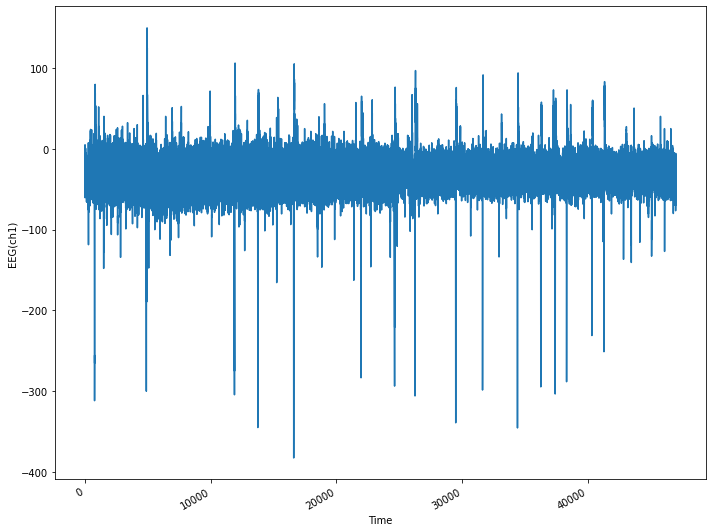

In [6]:
fig, ax = plt.subplots()

ax.plot(df['ch1'])
ax.set_xlabel('Time')
ax.set_ylabel('EEG(ch1)')

#plt.xticks(np.arange(7, 40000, 30), ['30','60','90','120','180','210','240'])
#plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()
# clear daily seaonality

In [7]:
import datetime
df['lsl_ts'] = df['lsl_ts'].astype('int')
df['unix_ts'] = df['unix_ts'].astype('int')
df['time1'] = df['lsl_ts'].apply(lambda x : datetime.datetime.utcfromtimestamp(x).strftime('%H:%M:%S'))
df['time2'] = df['unix_ts'].apply(lambda x : datetime.datetime.utcfromtimestamp(x).strftime('%H:%M:%S'))

In [8]:
df

,id,lsl_ts,unix_ts,ch1,ch2,ch3,ch4,ch5,time1,time2
0,63312,430888,1671587276,0.000000,0.000000,0.000000,0.000000,-0.488281,23:41:28,01:47:56
1,63313,430888,1671587276,0.000000,-0.488281,-0.488281,0.000000,0.488281,23:41:28,01:47:56
2,63314,430888,1671587276,-2.441406,-34.179688,0.000000,-1.464844,-0.976562,23:41:28,01:47:56
3,63315,430888,1671587276,4.882812,96.679688,-3.417969,2.929688,-3.906250,23:41:28,01:47:56
4,63316,430888,1671587276,-24.902344,-425.781250,10.253906,-16.601562,25.878906,23:41:28,01:47:56
...,...,...,...,...,...,...,...,...,...,...
47023,110335,431072,1671587460,-47.363281,-248.046875,-30.761719,-55.664062,-167.480469,23:44:32,01:51:00
47024,110336,431072,1671587460,-27.832031,310.546875,-30.273438,-44.921875,-131.835938,23:44:32,01:51:00
47025,110337,431072,1671587460,-21.484375,40.039062,-35.644531,-34.667969,280.761719,23:44:32,01:51:00
47026,110338,431072,1671587460,-47.851562,-129.394531,-36.621094,-43.945312,170.898438,23:44:32,01:51:00


In [9]:
df['time1'].value_counts(ascending = True)
#每一秒完整的資料筆數有不同(約235~279筆)

23:41:28     67
23:44:32    107
23:41:32    235
23:43:33    238
23:41:41    238
           ... 
23:43:36    275
23:43:51    276
23:42:00    278
23:42:08    278
23:43:07    279
Name: time1, Length: 185, dtype: int64

In [10]:
df = df[df['time1'].between("23:41:29", "23:44:31")]
#刪除頭尾各一秒的資料後，剩餘182秒的完整資料
#46854/182 = 257.43956043956047，約257

In [11]:
df.shape

(46854, 10)

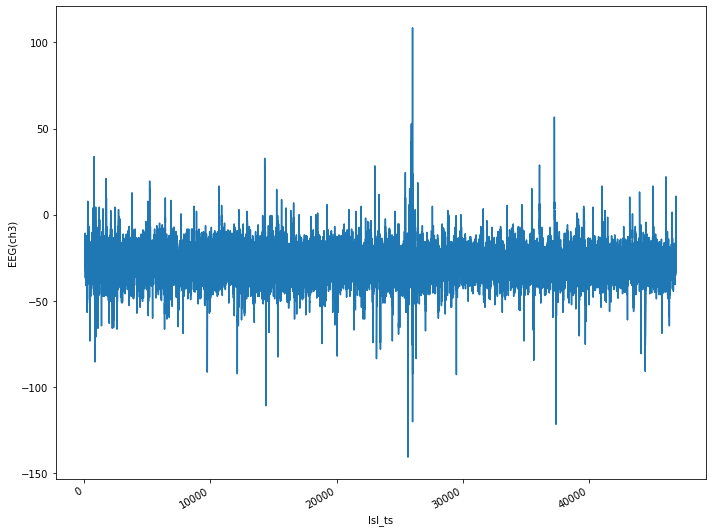

In [12]:
fig, ax = plt.subplots()

ax.plot(df.ch3)
ax.set_xlabel('lsl_ts')
ax.set_ylabel('EEG(ch3)')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [13]:
df.describe()

,id,lsl_ts,unix_ts,ch1,ch2,ch3,ch4,ch5
count,46854.000000,46854.000000,4.685400e+04,46854.000000,46854.000000,46854.000000,46854.000000,46854.000000
mean,86805.500000,430979.992402,1.671587e+09,-31.314904,-49.823258,-28.536576,-33.772380,-12.886742
std,13525.729093,52.827070,5.283060e+01,28.332560,462.483715,10.143718,27.645241,183.176627
min,63379.000000,430889.000000,1.671587e+09,-382.324219,-1000.000000,-140.625000,-382.324219,-439.941406
25%,75092.250000,430934.000000,1.671587e+09,-43.945312,-393.554688,-33.691406,-43.457031,-139.160156
50%,86805.500000,430980.000000,1.671587e+09,-30.273438,-42.968750,-28.320312,-33.203125,-47.363281
75%,98518.750000,431026.000000,1.671587e+09,-17.089844,307.983398,-22.949219,-22.949219,69.824219
max,110232.000000,431071.000000,1.671587e+09,149.414062,999.023438,108.398438,153.808594,812.500000


In [14]:
df = df.drop(['lsl_ts', 'id', 'time1', 'time2'],axis=1)

In [15]:
df

,unix_ts,ch1,ch2,ch3,ch4,ch5
67,1671587277,-18.554688,-885.742188,-19.531250,-0.976562,582.519531
68,1671587277,-39.062500,-1000.000000,-20.507812,-2.441406,514.160156
69,1671587277,-36.621094,-669.921875,-18.066406,3.417969,292.968750
70,1671587277,-14.648438,445.312500,-10.742188,2.441406,-59.082031
71,1671587277,-6.347656,785.156250,-16.601562,-13.671875,-114.746094
...,...,...,...,...,...,...
46916,1671587460,-64.453125,86.425781,-26.367188,-56.152344,-297.363281
46917,1671587460,-47.851562,-66.894531,-28.320312,-45.410156,-181.152344
46918,1671587460,-27.343750,365.234375,-25.390625,-33.203125,-97.656250
46919,1671587460,-34.179688,471.679688,-30.761719,-34.667969,-171.386719


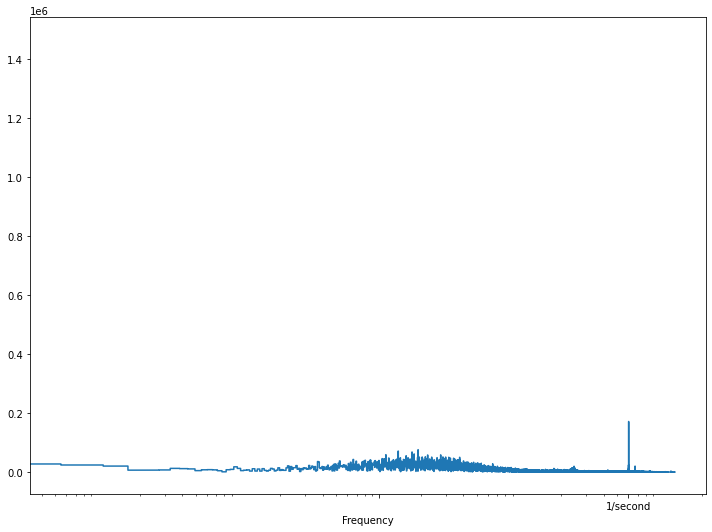

In [16]:

fft = tf.signal.rfft(df['ch1'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['ch1'])
second = 257
second_per_dataset = n_sample_h / second

f_per_second = f_per_dataset / second_per_dataset

plt.step(f_per_second, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 60], ['', '1/second'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


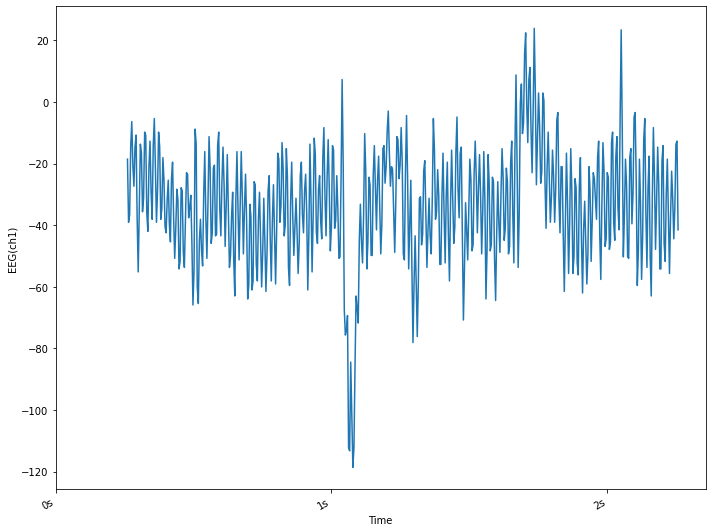

In [17]:
fig, ax = plt.subplots()

ax.plot(df['ch1'][0:514])
ax.set_xlabel('Time')
ax.set_ylabel('EEG(ch1)')

plt.xticks([0,257, 514], ['0s','1s', '2s'])

fig.autofmt_xdate()
plt.tight_layout()

**Data spliting**

In [18]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((32797, 6), (9371, 6), (4686, 6))

**特徵縮放**

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

**Data Window**

In [20]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='ch1', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [21]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['ch1']) #一單位預測下一單位

In [22]:
wide_window = DataWindow(input_width=257, label_width=257, shift=257, label_columns=['ch1']) #一秒預測下一秒

# **Baseline Model (MAE:0.0493, 不採用)**

In [23]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [24]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['ch1'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [25]:
column_indices

{'unix_ts': 0, 'ch1': 1, 'ch2': 2, 'ch3': 3, 'ch4': 4, 'ch5': 5}

In [26]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(wide_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(wide_window.test,verbose=0)

277/277 [==============================] - 2s 5ms/step - loss: 0.0068 - mean_absolute_error: 0.0493


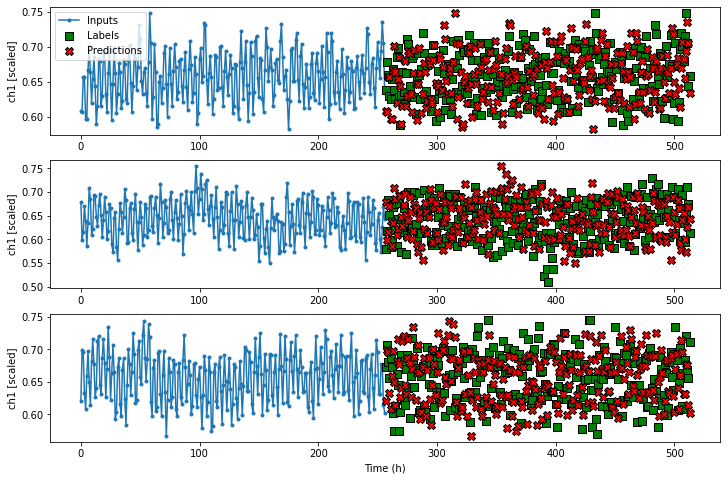

In [27]:
wide_window.plot(baseline_last)

In [28]:
print(performance['Baseline - Last'][1])

0.03332673758268356


# **Repeat Basline Model (MAE: 0.1761)**

In [29]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [30]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['ch1'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(wide_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(wide_window.test, verbose=0)

277/277 [==============================] - 1s 5ms/step - loss: 0.0552 - mean_absolute_error: 0.1761


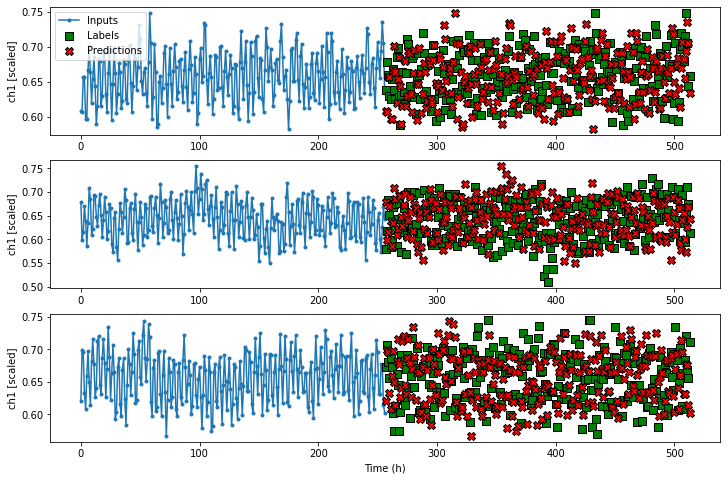

In [31]:
wide_window.plot(ms_baseline_repeat)

# **Linear Model (MAE: 0.0353-Test, MAE: 0.0317-Vali)**

In [32]:
def compile_and_fit(model, window, patience=3, max_epochs=50): #
    early_stopping = EarlyStopping(monitor='val_loss',
                    patience=patience,mode='min')
    model.compile(loss=MeanSquaredError(),
              optimizer=Adam(),
              metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
              epochs=max_epochs, #max_epochs=50
              validation_data=window.val,
              callbacks=[early_stopping])   #We use the validation set to caluculate the validation set 
    return history

In [33]:
#Construct a linear model
#Since it must output only one value: the prediction for traffic volume at the next timestep. 
linear = Sequential([
    Dense(units=1, kernel_initializer = tf.initializers.zeros)
])

#Training the model
history = compile_and_fit(linear, wide_window)

Epoch 1/50
1009/1009 [==============================] - 7s 6ms/step - loss: 0.0333 - mean_absolute_error: 0.1157 - val_loss: 0.0076 - val_mean_absolute_error: 0.0656
Epoch 2/50
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0493 - val_loss: 0.0047 - val_mean_absolute_error: 0.0435
Epoch 3/50
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0422 - val_loss: 0.0042 - val_mean_absolute_error: 0.0380
Epoch 4/50
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0391 - val_loss: 0.0040 - val_mean_absolute_error: 0.0365
Epoch 5/50
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0381 - val_loss: 0.0039 - val_mean_absolute_error: 0.0355
Epoch 6/50
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0374 - val_loss: 0.0037 - val_mean_absolute_error: 0.0345
Epoc

In [34]:
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

277/277 [==============================] - 1s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0317


# **DNN(MAE: 0.0344-Test, MAE: 0.0387-Vali)**

In [ ]:
#Construct a DNN model
dense = Sequential([
    Dense(units=64,activation='relu'), #First hidden layer with 64 nurtions. Specify the activation function to be ReLU
    Dense(units=64,activation='relu'),
    Dense(units=1) #The output layer has only one nurion, as we output only one value
])

#Training the model
history = compile_and_fit(dense, wide_window)

Epoch 1/50
1009/1009 [==============================] - 23s 22ms/step - loss: 0.0081 - mean_absolute_error: 0.0461 - val_loss: 0.0037 - val_mean_absolute_error: 0.0339
Epoch 2/50
1009/1009 [==============================] - 22s 21ms/step - loss: 0.0029 - mean_absolute_error: 0.0348 - val_loss: 0.0036 - val_mean_absolute_error: 0.0335
Epoch 3/50
1009/1009 [==============================] - 22s 22ms/step - loss: 0.0029 - mean_absolute_error: 0.0346 - val_loss: 0.0039 - val_mean_absolute_error: 0.0365
Epoch 4/50
1009/1009 [==============================] - 25s 25ms/step - loss: 0.0029 - mean_absolute_error: 0.0345 - val_loss: 0.0038 - val_mean_absolute_error: 0.0354
Epoch 5/50
1009/1009 [==============================] - 21s 20ms/step - loss: 0.0029 - mean_absolute_error: 0.0344 - val_loss: 0.0038 - val_mean_absolute_error: 0.0352


In [ ]:
val_performance['dense'] = dense.evaluate(wide_window.val)
performance['dense'] = dense.evaluate(wide_window.test, verbose=0)

277/277 [==============================] - 3s 11ms/step - loss: 0.0038 - mean_absolute_error: 0.0352


# **LSTM (MAE: 0.025-Test, Mae: 0.0268-Vali)**

In [ ]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True), 
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

history = compile_and_fit(lstm_model, wide_window)

# **CNN (MAE: 0.0251-Test, MAE: 0.0289-Vali)**

CNN MULTI WINDOW

In [36]:
kernel_width = 3
cnn_label_width = 257
input_width = cnn_label_width + kernel_width - 1

cnn_wide_window = DataWindow(input_width=input_width, label_width=cnn_label_width, shift=257, label_columns=['ch1'])

In [37]:
cnn_model = Sequential([
    Conv1D(32, activation = 'relu', kernel_size = (kernel_width)), 
    Dense(units = 32, activation = 'relu'), 
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

history = compile_and_fit(cnn_model, cnn_wide_window)

Epoch 1/50
1009/1009 [==============================] - 17s 16ms/step - loss: 0.0120 - mean_absolute_error: 0.0501 - val_loss: 0.0036 - val_mean_absolute_error: 0.0327
Epoch 2/50
1009/1009 [==============================] - 16s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0259 - val_loss: 0.0034 - val_mean_absolute_error: 0.0301
Epoch 3/50
1009/1009 [==============================] - 16s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0256 - val_loss: 0.0032 - val_mean_absolute_error: 0.0274
Epoch 4/50
1009/1009 [==============================] - 16s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0255 - val_loss: 0.0032 - val_mean_absolute_error: 0.0273
Epoch 5/50
1009/1009 [==============================] - 18s 18ms/step - loss: 0.0023 - mean_absolute_error: 0.0254 - val_loss: 0.0032 - val_mean_absolute_error: 0.0270
Epoch 6/50
1009/1009 [==============================] - 16s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0252 - val_loss: 0.0032 - val_mean_absolute_error:

# **CNN+LSTM (MAE: 0.0243-Test, MAE: 0.0260-Vali)**
要跑很久很久.....

In [38]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation = 'relu', kernel_size = (kernel_width)), 
    LSTM(32, return_sequences=True), 
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

history = compile_and_fit(cnn_lstm_model, cnn_wide_window)

Epoch 1/50
1009/1009 [==============================] - 129s 125ms/step - loss: 0.0093 - mean_absolute_error: 0.0432 - val_loss: 0.0032 - val_mean_absolute_error: 0.0272
Epoch 2/50
1009/1009 [==============================] - 132s 131ms/step - loss: 0.0024 - mean_absolute_error: 0.0261 - val_loss: 0.0032 - val_mean_absolute_error: 0.0275
Epoch 3/50
 498/1009 [=============>................] - ETA: 1:02 - loss: 0.0023 - mean_absolute_error: 0.0256

KeyboardInterrupt: ignored